In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Set project path
root = Path(r"C:\Users\mahsa\Downloads\transdiagnostic project\ds005237\phenotype")

# Load main tables
demos = pd.read_csv(root / "demos.tsv", sep=",", encoding="latin-1", skiprows=1)
shaps = pd.read_csv(root / "shaps01.tsv", sep="\t")
teps = pd.read_csv(root / "teps01.tsv", sep="\t")
madrs = pd.read_csv(root / "madrs01.tsv", sep="\t")
qids = pd.read_csv(root / "qids01.tsv", sep="\t")
panss = pd.read_csv(root / "panss01.tsv", sep="\t")

print("Loaded tables:")
for name, df in [("demos", demos), ("shaps", shaps), ("teps", teps), 
                 ("madrs", madrs), ("qids", qids), ("panss", panss)]:
    print(name, df.shape)

Loaded tables:
demos (245, 116)
shaps (230, 26)
teps (233, 34)
madrs (232, 17)
qids (226, 23)
panss (232, 38)


In [4]:
import numpy as np
import pandas as pd

# 1) subjectkey as string everywhere
for df in [demos, shaps, teps, madrs, qids, panss]:
    df["subjectkey"] = df["subjectkey"].astype(str)

# 2) Keep demos as-is (so we don't destroy text diagnosis columns)
demos_n = demos.copy()

# 3) For scale tables: coerce all non-ID columns to numeric
def scales_to_numeric(df):
    df = df.copy()
    for c in df.columns:
        if c != "subjectkey":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

shaps_n = scales_to_numeric(shaps)
teps_n  = scales_to_numeric(teps)
madrs_n = scales_to_numeric(madrs)
qids_n  = scales_to_numeric(qids)
panss_n = scales_to_numeric(panss)

# 4) Replace coded missing values column-by-column (avoids pandas block bug)
MISSING_CODES = {777, 888, 999, -777, -888, -999}

def replace_missing_codes_safely(df):
    df = df.copy()
    for c in df.columns:
        if c != "subjectkey" and pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].where(~df[c].isin(MISSING_CODES), np.nan)
    return df

shaps_n = replace_missing_codes_safely(shaps_n)
teps_n  = replace_missing_codes_safely(teps_n)
madrs_n = replace_missing_codes_safely(madrs_n)
qids_n  = replace_missing_codes_safely(qids_n)
panss_n = replace_missing_codes_safely(panss_n)

# 5) Drop duplicate admin columns from scale tables if they exist
DROP_ADMIN = {"src_subject_id", "interview_date", "interview_age", "sex"}

def scale_only(df):
    cols = ["subjectkey"] + [c for c in df.columns if c not in DROP_ADMIN and c != "subjectkey"]
    return df[cols]

# 6) Merge: demos + scales
merged = demos_n.copy()
for df in [scale_only(shaps_n), scale_only(teps_n), scale_only(madrs_n), scale_only(qids_n), scale_only(panss_n)]:
    merged = merged.merge(df, on="subjectkey", how="inner")

print("Merged shape:", merged.shape)

# 7) Quick sanity check: do we still have coded missings?
# (Counts of remaining 999-like values should be zero because scales are numeric now)
def count_codes(df, code):
    num = 0
    for c in df.columns:
        if c != "subjectkey" and pd.api.types.is_numeric_dtype(df[c]):
            num += int((df[c] == code).sum(skipna=True))
    return num

print("Remaining 999 codes in merged:", count_codes(merged, 999))

Merged shape: (208, 229)
Remaining 999 codes in merged: 1500


In [7]:
import re
import numpy as np
import pandas as pd

missing_pat = re.compile(r"^\s*-?(777|888|999)(\.0+)?\s*$")
MISSING_NUMS = {777, 888, 999, -777, -888, -999}

def clean_demos(df):
    df = df.copy()
    df["subjectkey"] = df["subjectkey"].astype(str)

    # Clean string-like columns (replace token-like 777/888/999 with NaN)
    str_cols = df.select_dtypes(include=["object", "string"]).columns
    for c in str_cols:
        if c == "subjectkey":
            continue
        s = df[c].astype("string").str.strip()
        df[c] = s.where(~s.str.match(missing_pat, na=False), np.nan)

    # Clean numeric columns (replace numeric codes with NaN)
    num_cols = df.select_dtypes(include=["number"]).columns
    for c in num_cols:
        df[c] = df[c].where(~df[c].isin(MISSING_NUMS), np.nan)

    return df

# Clean demos now
demos_n = clean_demos(demos)

# Re-merge using your already-cleaned scale tables (shaps_n, teps_n, madrs_n, qids_n, panss_n)
DROP_ADMIN = {"src_subject_id", "interview_date", "interview_age", "sex"}
def scale_only(df):
    cols = ["subjectkey"] + [c for c in df.columns if c not in DROP_ADMIN and c != "subjectkey"]
    return df[cols]

merged = demos_n.copy()
for df in [scale_only(shaps_n), scale_only(teps_n), scale_only(madrs_n), scale_only(qids_n), scale_only(panss_n)]:
    merged = merged.merge(df, on="subjectkey", how="inner")

print("Merged shape:", merged.shape)

# Count remaining 999-like ONLY in numeric columns (this is what matters for modeling)
num_cols = merged.select_dtypes(include=["number"]).columns
remaining_numeric_999 = int((merged[num_cols] == 999).sum().sum())
remaining_numeric_888 = int((merged[num_cols] == 888).sum().sum())
remaining_numeric_777 = int((merged[num_cols] == 777).sum().sum())

print("Remaining numeric 999:", remaining_numeric_999)
print("Remaining numeric 888:", remaining_numeric_888)
print("Remaining numeric 777:", remaining_numeric_777)

Merged shape: (208, 229)
Remaining numeric 999: 0
Remaining numeric 888: 0
Remaining numeric 777: 0


In [8]:
# Helper to sum columns safely
def sum_numeric(df, cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].apply(pd.to_numeric, errors="coerce").sum(axis=1)

# --- Anhedonia domain ---
shaps_cols = [c for c in merged.columns if c.startswith("shaps")]
teps_cols  = [c for c in merged.columns if c.startswith("teps")]

merged["SHAPS_total"] = sum_numeric(merged, shaps_cols)
merged["TEPS_total"]  = sum_numeric(merged, teps_cols)

# --- Depression domain ---
madrs_cols = [c for c in merged.columns if c.startswith("madrs")]
qids_cols  = [c for c in merged.columns if c.startswith("qids")]

merged["MADRS_total"] = sum_numeric(merged, madrs_cols)
merged["QIDS_total"]  = sum_numeric(merged, qids_cols)

# --- Psychosis domain ---
if "panss_positive" in merged.columns:
    merged["PANSS_positive"] = merged["panss_positive"]
    merged["PANSS_negative"] = merged["panss_negative"]
    merged["PANSS_general"]  = merged["panss_general"]
else:
    pos_cols = [c for c in merged.columns if c.startswith("pos_p")]
    neg_cols = [c for c in merged.columns if c.startswith("neg_n")]
    gen_cols = [c for c in merged.columns if c.startswith("gen_g")]

    merged["PANSS_positive"] = sum_numeric(merged, pos_cols)
    merged["PANSS_negative"] = sum_numeric(merged, neg_cols)
    merged["PANSS_general"]  = sum_numeric(merged, gen_cols)

# --- Summary table ---
domains = [
    "SHAPS_total",
    "TEPS_total",
    "MADRS_total",
    "QIDS_total",
    "PANSS_positive",
    "PANSS_negative",
    "PANSS_general"
]

summary = merged[domains].agg(["count", "mean", "std", "min", "max"]).T
summary

C:\Users\mahsa\AppData\Local\Temp\ipykernel_15132\275609810.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged["SHAPS_total"] = sum_numeric(merged, shaps_cols)
C:\Users\mahsa\AppData\Local\Temp\ipykernel_15132\275609810.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged["TEPS_total"]  = sum_numeric(merged, teps_cols)
C:\Users\mahsa\AppData\Local\Temp\ipykernel_15132\275609810.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

,count,mean,std,min,max
SHAPS_total,208.0,176.698394,137.224497,-89.324,936.917
TEPS_total,208.0,479.801192,954.130726,-5400.000,5176.288
MADRS_total,208.0,-2245.475962,15202.351638,-109989.000,78.000
QIDS_total,208.0,0.000000,0.000000,0.000,0.000
PANSS_positive,204.0,8.210784,3.057685,5.000,30.000
PANSS_negative,204.0,9.078431,3.978232,1.000,27.000
PANSS_general,204.0,21.088235,6.255012,3.000,47.000


In [9]:
# Inspect columns for each scale
print("SHAPS columns:")
print([c for c in shaps.columns if c.startswith("shaps")])

print("\nTEPS columns:")
print([c for c in teps.columns if c.startswith("teps")])

print("\nMADRS columns:")
print([c for c in madrs.columns if c.startswith("madrs")])

print("\nQIDS columns:")
print([c for c in qids.columns])

SHAPS columns:
['shaps1a', 'shaps2a', 'shaps3a', 'shaps4a', 'shaps5a', 'shaps6a', 'shaps7a', 'shaps_8a', 'shaps9a', 'shaps10a', 'shaps11a', 'shaps12a', 'shaps13a', 'shaps14a', 'shaps_total', 'shaps_time_First_Click', 'shaps_time_Last_Click', 'shaps_time_Page_Submit', 'shaps_time_Click_Count']

TEPS columns:
['teps1', 'teps2', 'teps3', 'teps4', 'teps5', 'teps6', 'teps7', 'teps8', 'teps9', 'teps10', 'teps11', 'teps12', 'teps13', 'teps14', 'teps15', 'teps16', 'teps17', 'teps18', 'teps_ap', 'teps_cp', 'teps_time_First_Click', 'teps_time_Last_Click', 'teps_time_Page_Submit', 'teps_time_Click_Count', 'teps_tot_timing']

MADRS columns:
['madrssad', 'madrspes', 'madrssui', 'madrsslp', 'madrsfee', 'madrslas', 'madrscon', 'madrsten', 'madrsapp', 'madrsaps', 'madrstot']

QIDS columns:
['subjectkey', 'src_subject_id', 'interview_date', 'interview_age', 'sex', 'level', 'vsoin', 'vmnin', 'vemin', 'vhysm', 'vmdsd', 'vapdc', 'vapin', 'vwtdc', 'vwtin', 'vcntr', 'vvwsf', 'vsuic', 'vintr', 'vengy', 'vslo

In [10]:
# Use validated totals instead of raw summation

# --- Anhedonia ---
merged["SHAPS_total"] = pd.to_numeric(merged["shaps_total"], errors="coerce")
merged["TEPS_AP"] = pd.to_numeric(merged["teps_ap"], errors="coerce")
merged["TEPS_CP"] = pd.to_numeric(merged["teps_cp"], errors="coerce")

# --- Depression ---
merged["MADRS_total"] = pd.to_numeric(merged["madrstot"], errors="coerce")
merged["QIDS_total"] = pd.to_numeric(merged["qvtot"], errors="coerce")

# --- Psychosis ---
merged["PANSS_positive"] = pd.to_numeric(merged["panss_positive"], errors="coerce")
merged["PANSS_negative"] = pd.to_numeric(merged["panss_negative"], errors="coerce")
merged["PANSS_general"] = pd.to_numeric(merged["panss_general"], errors="coerce")

# Summary
domains = [
    "SHAPS_total",
    "TEPS_AP",
    "TEPS_CP",
    "MADRS_total",
    "QIDS_total",
    "PANSS_positive",
    "PANSS_negative",
    "PANSS_general"
]

summary = merged[domains].agg(["count", "mean", "std", "min", "max"]).T
summary

C:\Users\mahsa\AppData\Local\Temp\ipykernel_15132\4036590966.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged["TEPS_AP"] = pd.to_numeric(merged["teps_ap"], errors="coerce")
C:\Users\mahsa\AppData\Local\Temp\ipykernel_15132\4036590966.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged["TEPS_CP"] = pd.to_numeric(merged["teps_cp"], errors="coerce")


,count,mean,std,min,max
SHAPS_total,206.0,1.179612,2.291399,0.0,12.0
TEPS_AP,204.0,43.186275,8.712971,15.0,59.0
TEPS_CP,204.0,37.955882,6.306070,15.0,48.0
MADRS_total,208.0,-185.331731,1377.533352,-9999.0,39.0
QIDS_total,199.0,5.618090,4.611675,0.0,22.0
PANSS_positive,204.0,8.210784,3.057685,5.0,30.0
PANSS_negative,204.0,9.078431,3.978232,1.0,27.0
PANSS_general,204.0,21.088235,6.255012,3.0,47.0


In [11]:
# Fix MADRS special missing value
merged.loc[merged["MADRS_total"] < -1000, "MADRS_total"] = np.nan

# Recheck summary
domains = [
    "SHAPS_total",
    "TEPS_AP",
    "TEPS_CP",
    "MADRS_total",
    "QIDS_total",
    "PANSS_positive",
    "PANSS_negative",
    "PANSS_general"
]

merged[domains].agg(["count", "mean", "std", "min", "max"]).T

,count,mean,std,min,max
SHAPS_total,206.0,1.179612,2.291399,0.0,12.0
TEPS_AP,204.0,43.186275,8.712971,15.0,59.0
TEPS_CP,204.0,37.955882,6.306070,15.0,48.0
MADRS_total,204.0,7.093137,9.124004,0.0,39.0
QIDS_total,199.0,5.618090,4.611675,0.0,22.0
PANSS_positive,204.0,8.210784,3.057685,5.0,30.0
PANSS_negative,204.0,9.078431,3.978232,1.0,27.0
PANSS_general,204.0,21.088235,6.255012,3.0,47.0


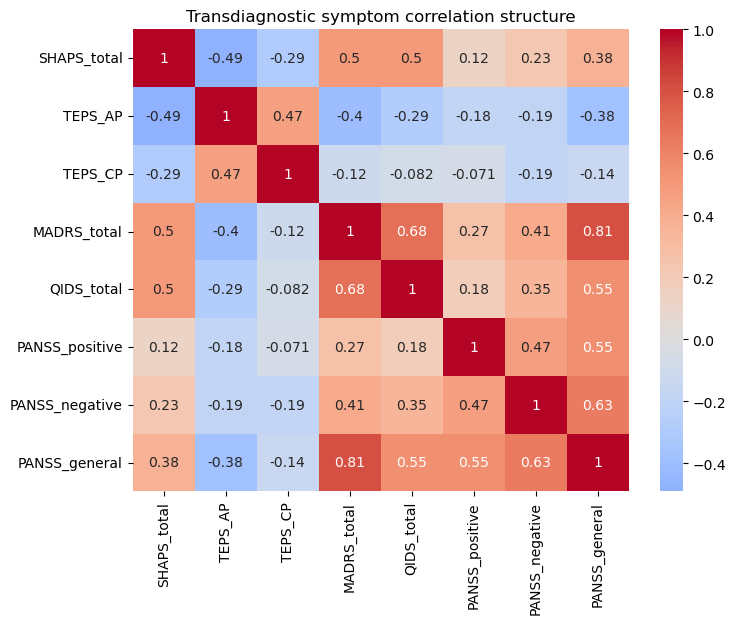

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

domains = [
    "SHAPS_total",
    "TEPS_AP",
    "TEPS_CP",
    "MADRS_total",
    "QIDS_total",
    "PANSS_positive",
    "PANSS_negative",
    "PANSS_general"
]

corr = merged[domains].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Transdiagnostic symptom correlation structure")
plt.show()

In [13]:
!conda install seaborn -y

Jupyter detected...
3 channel Terms of Service accepted
Channels:
 - defaults
Platform: win-64
Solving environment: done

## Package Plan ##

  environment location: C:\Users\mahsa\anaconda3\envs\tcp311

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    contourpy-1.3.3            |  py311h214f63a_0        11.3 MB
    cycler-0.12.1              |  py311haa95532_0          19 KB
    fonttools-4.61.0           |  py311h02ab6af_0         3.7 MB
    freetype-2.14.1            |       hfbffc0b_0         514 KB
    kiwisolver-1.4.9           |  py311h03f52e7_0          81 KB
    lcms2-2.16                 |       hb4a4139_0         566 KB
    lerc-3.0                   |       hd77b12b_0         120 KB
    libdeflate-1.17            |       h2bbff1b_1         153 KB
    libhwloc-2.12.1            |default_hfa10c62_1000         2.3 MB
    libiconv-1.18     



==> WARNING: A newer version of conda exists. <==
    current version: 25.11.0
    latest version: 26.1.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
from sklearn.decomposition import PCA

In [17]:
X = merged[domains].dropna()

In [18]:
X.shape

(192, 8)

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [21]:
import numpy as np
np.round(pca.explained_variance_ratio_, 3)

array([0.47 , 0.167, 0.113, 0.086, 0.054, 0.053, 0.043, 0.014])

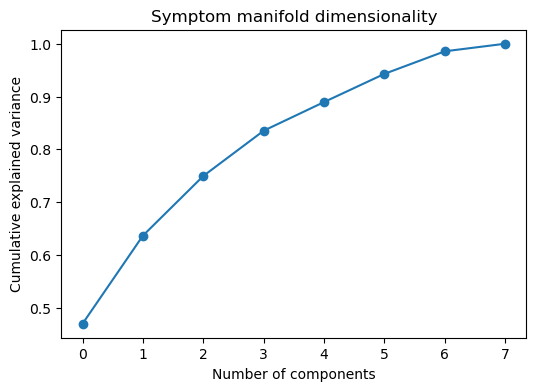

In [22]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Symptom manifold dimensionality")
plt.show()

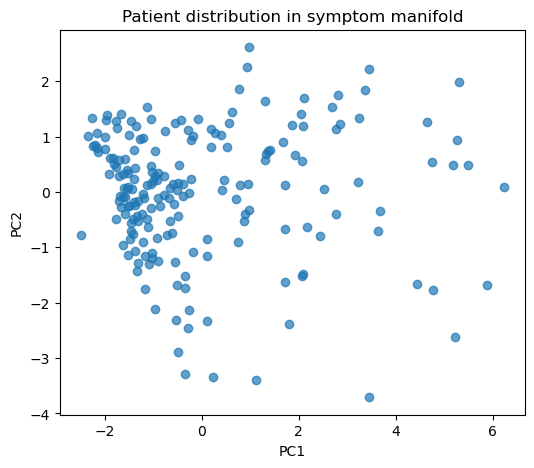

In [23]:
X_scaled = scaler.fit_transform(X)
Z = pca.transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Patient distribution in symptom manifold")
plt.show()

In [24]:
plt.figure(figsize=(6,5))

for dx in merged["Primary_Dx"].unique():
    subset = merged.loc[X.index]
    idx = subset["Primary_Dx"] == dx
    plt.scatter(Z[idx,0], Z[idx,1], label=dx, alpha=0.6)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Symptom manifold colored by diagnosis")
plt.legend()
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 600x500 with 0 Axes>

In [25]:
subset = merged.loc[X.index].copy()

In [26]:
plt.figure(figsize=(6,5))

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [27]:
for dx in subset["Primary_Dx"].unique():
    idx = subset["Primary_Dx"] == dx
    plt.scatter(Z[idx.values,0], Z[idx.values,1], label=dx, alpha=0.6)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

C:\Users\mahsa\AppData\Local\Temp\ipykernel_15132\3907125321.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


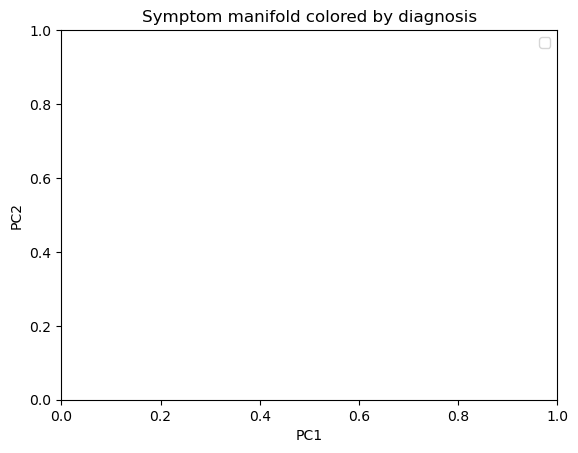

In [28]:
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Symptom manifold colored by diagnosis")
plt.legend()
plt.show()

In [29]:
subset.shape

(192, 238)

In [30]:
subset["Primary_Dx"].value_counts(dropna=False).head(10)

Primary_Dx
<NA>              75
MDD               16
GAD               11
PTSD              10
past MDD           9
BP1                6
social anxiety     6
Dysthymia          4
past PTSD          4
past GAD           4
Name: count, dtype: Int64

In [31]:
subset["Dx_clean"] = subset["Primary_Dx"].astype("string").fillna("Unknown")

In [32]:
subset["Dx_clean"].value_counts()

Dx_clean
Unknown                                                 75
MDD                                                     16
GAD                                                     11
PTSD                                                    10
past MDD                                                 9
BP1                                                      6
social anxiety                                           6
Dysthymia                                                4
past PTSD                                                4
past GAD                                                 4
SZA                                                      3
SZ                                                       3
Past MDD                                                 3
BPI                                                      3
anxiety NOS                                              3
dysthymia                                                3
BP2                                            

In [33]:
def group_dx(dx):
    dx = str(dx).lower()
    
    if "unknown" in dx or dx == "nan":
        return "Unknown"
    
    if any(x in dx for x in ["mdd", "depress", "dysthym", "pmdd", "cyclothym"]):
        return "Mood"
    
    if any(x in dx for x in ["gad", "anxiety", "ptsd", "panic", "phobia", "ocd"]):
        return "Anxiety"
    
    if any(x in dx for x in ["sz", "sza", "psych"]):
        return "Psychotic"
    
    if any(x in dx for x in ["bp", "bipolar"]):
        return "Bipolar"
    
    if any(x in dx for x in ["adhd", "aud", "sub", "cud", "eating"]):
        return "Other"
    
    return "Other"

subset["Dx_group"] = subset["Dx_clean"].apply(group_dx)

subset["Dx_group"].value_counts()

Dx_group
Unknown      75
Mood         43
Anxiety      43
Bipolar      12
Other        12
Psychotic     7
Name: count, dtype: int64

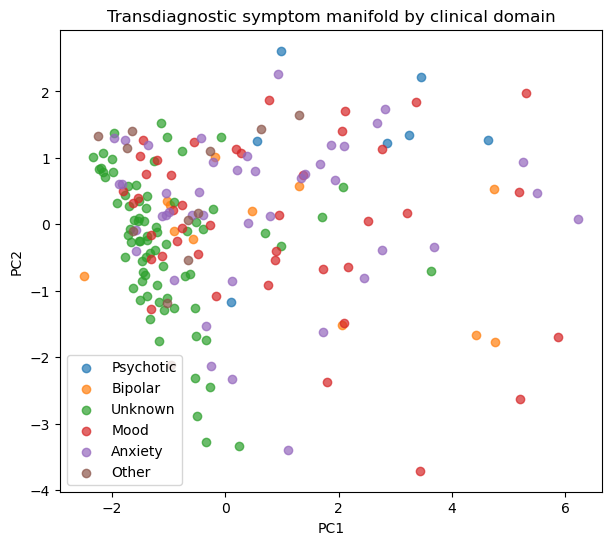

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

for g in subset["Dx_group"].unique():
    idx = subset["Dx_group"] == g
    plt.scatter(Z[idx, 0], Z[idx, 1], label=g, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Transdiagnostic symptom manifold by clinical domain")
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import silhouette_score

In [36]:
labels = subset["Dx_group"]

In [37]:
silhouette_score(Z, labels)

-0.049342156948058456

In [38]:
from sklearn.cluster import KMeans

In [39]:
kmeans = KMeans(n_clusters=4, random_state=42)

In [40]:
kmeans = KMeans(n_clusters=4, random_state=42)

In [41]:
clusters = kmeans.fit_predict(Z)

In [42]:
np.bincount(clusters)

array([96, 16, 36, 44])

In [43]:
silhouette_score(Z, clusters)

0.24606703034289054

In [44]:
cluster_df = subset.copy()
cluster_df["cluster"] = clusters

cluster_summary = cluster_df.groupby("cluster")[domains].mean()
cluster_summary

,SHAPS_total,TEPS_AP,TEPS_CP,MADRS_total,QIDS_total,PANSS_positive,PANSS_negative,PANSS_general
cluster,,,,,,,,
0,0.166667,47.677083,41.822917,1.895833,3.760417,7.229167,7.468750,17.718750
1,6.562500,29.000000,32.812500,24.625000,11.812500,9.562500,13.125000,31.812500
2,0.944444,39.666667,29.861111,1.777778,3.083333,7.055556,7.694444,17.500000
3,1.227273,40.863636,38.818182,16.613636,8.795455,9.931818,10.568182,26.590909


In [45]:
pd.crosstab(cluster_df["cluster"], cluster_df["Dx_group"])

Dx_group,Anxiety,Bipolar,Mood,Other,Psychotic,Unknown
cluster,,,,,,
0,17,6,16,8,0,49
1,4,4,7,0,0,1
2,7,0,5,2,1,21
3,15,2,15,2,6,4


In [46]:
cluster_df.groupby("cluster")[["interview_age"]].describe()

interview_age                                                        \
                count        mean         std    min     25%    50%     75%   
cluster                                                                       
0                96.0  374.072917  144.035247  217.0  272.50  317.0  443.50   
1                16.0  489.875000  205.015081  232.0  257.25  544.5  646.75   
2                36.0  404.250000  146.868916  220.0  295.00  365.0  482.25   
3                44.0  448.454545  174.914126  230.0  301.75  389.0  575.50   

                
           max  
cluster         
0        780.0  
1        767.0  
2        768.0  
3        774.0

In [47]:
from scipy.stats import f_oneway

groups = [cluster_df[cluster_df["cluster"] == i]["interview_age"].dropna() for i in range(4)]
f_oneway(*groups)

F_onewayResult(statistic=np.float64(3.887199996503652), pvalue=np.float64(0.010003617990391277))

In [49]:
X_np = X.to_numpy()

In [50]:
type(X_np), X_np.shape

(numpy.ndarray, (192, 8))

In [51]:
from sklearn.linear_model import LinearRegression

age = subset["interview_age"].to_numpy().reshape(-1, 1)

X_res = X_np.copy()
for i in range(X_res.shape[1]):
    m = LinearRegression().fit(age, X_np[:, i])
    X_res[:, i] = X_np[:, i] - m.predict(age)

In [52]:
# PCA after removing age effects
pca_res = PCA()
Z_res = pca_res.fit_transform(StandardScaler().fit_transform(X_res))

np.round(pca_res.explained_variance_ratio_, 3)

array([0.457, 0.174, 0.11 , 0.09 , 0.056, 0.055, 0.044, 0.015])

In [53]:
kmeans_res = KMeans(n_clusters=4, random_state=42)
clusters_res = kmeans_res.fit_predict(Z_res)

silhouette_score(Z_res, clusters_res)

0.28464614760737633

In [54]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(clusters, clusters_res)

0.5135864627381894

In [55]:
[c for c in merged.columns if "cgi" in c.lower() or "function" in c.lower()]

[]

In [56]:
[c for c in merged.columns if "age" in c.lower() or "onset" in c.lower() or "duration" in c.lower()]

['interview_age',
 'Age',
 'age_learn_eng',
 'dosage_meds',
 'dosage_meds_1_TEXT',
 'shaps_time_Page_Submit',
 'teps_time_Page_Submit']

In [60]:
merged = merged.copy()

In [61]:
merged.loc[X.index, "PC1"] = Z[:, 0]

In [63]:
[c for c in merged.columns if "clust" in c.lower()]

[]

In [64]:
merged.loc[X.index, "cluster"] = cluster_df["cluster"]

In [65]:
merged.loc[X.index, "cluster"].value_counts(dropna=False)

cluster
0.0    96
3.0    44
2.0    36
1.0    16
Name: count, dtype: int64

In [66]:
merged.loc[X.index].groupby("cluster")["PC1"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0.0,96.0,-1.270646,0.579865,-2.489991,-1.672355,-1.383037,-0.889865,0.198261
1.0,16.0,4.396371,1.302507,1.799010,3.584300,4.761639,5.267510,6.223530
2.0,36.0,-0.595328,0.767498,-1.627181,-1.186031,-0.581995,-0.264442,1.725807
3.0,44.0,1.660725,1.021379,0.188533,0.852663,1.539126,2.242007,4.639480


In [67]:
cluster_df.groupby("cluster")[domains].mean()

,SHAPS_total,TEPS_AP,TEPS_CP,MADRS_total,QIDS_total,PANSS_positive,PANSS_negative,PANSS_general
cluster,,,,,,,,
0,0.166667,47.677083,41.822917,1.895833,3.760417,7.229167,7.468750,17.718750
1,6.562500,29.000000,32.812500,24.625000,11.812500,9.562500,13.125000,31.812500
2,0.944444,39.666667,29.861111,1.777778,3.083333,7.055556,7.694444,17.500000
3,1.227273,40.863636,38.818182,16.613636,8.795455,9.931818,10.568182,26.590909


In [68]:
from scipy.stats import spearmanr

for d in domains:
    r, p = spearmanr(merged.loc[X.index, "PC1"], merged.loc[X.index, d])
    print(d, round(r,3), p)

SHAPS_total 0.629 1.38261589555966e-22
TEPS_AP -0.579 1.4089575226805075e-18
TEPS_CP -0.438 2.0540770211524931e-10
MADRS_total 0.804 9.16292842536808e-45
QIDS_total 0.691 1.4330272169736802e-28
PANSS_positive 0.501 1.4322380243106448e-13
PANSS_negative 0.682 1.1810278337921905e-27
PANSS_general 0.842 7.372099917690792e-53


In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# encode diagnosis
diag = pd.get_dummies(subset["Dx_group"], drop_first=True)

# model 1: diagnosis only
model1 = LinearRegression().fit(diag, merged.loc[X.index, "MADRS_total"])
pred1 = model1.predict(diag)
print("Diagnosis R2:", r2_score(merged.loc[X.index, "MADRS_total"], pred1))

# model 2: PC1 only
pc1 = merged.loc[X.index, ["PC1"]]
model2 = LinearRegression().fit(pc1, merged.loc[X.index, "MADRS_total"])
pred2 = model2.predict(pc1)
print("PC1 R2:", r2_score(merged.loc[X.index, "MADRS_total"], pred2))

Diagnosis R2: 0.25070677107939243
PC1 R2: 0.7789242929512773


In [70]:
# find cognitive or performance variables
[c for c in merged.columns if "tmb" in c.lower() or "cog" in c.lower() or "stroop" in c.lower()]

['TMB_ndays']

In [71]:
[c for c in merged.columns if "tmb" in c.lower() or "test" in c.lower()]

['Test_My_Brain', 'TMB_ndays']

In [73]:
files = sorted((root).glob("*.tsv"))

In [74]:
[f.name for f in files if "tmb" in f.name.lower()]

['tmb_dsm01.tsv',
 'tmb_dsm01_definitions.tsv',
 'tmb_fch01.tsv',
 'tmb_gradcpt01.tsv',
 'tmb_gradcpt01_definitions.tsv',
 'tmb_mer01.tsv',
 'tmb_mer01_definitions.tsv',
 'tmb_mr01.tsv',
 'tmb_mr01_definitions.tsv',
 'tmb_rt01.tsv',
 'tmb_rt01_definitions.tsv',
 'tmb_wsap01.tsv',
 'tmb_wsap01_definitions.tsv']

In [75]:
gradcpt = pd.read_csv(root / "tmb_gradcpt01.tsv", sep="\t", encoding="latin-1")
gradcpt.head()

,subjectkey,src_subject_id,interview_date,interview_age,sex,tmb_gcpt_score
0,NDAR_INVBB020WYD,PCM001,01/01/2023,356,M,96.87
1,NDAR_INVDW733XXB,PCM003,01/01/2023,352,M,56.25
2,NDAR_INVPF308MTF,PCM004,01/01/2023,374,M,56.25
3,NDAR_INVEV975LY3,PCM005,01/01/2023,767,F,78.12
4,NDAR_INVKV870NBK,PCM007,01/01/2023,582,F,87.50


In [76]:
gradcpt.shape

(217, 6)

In [77]:
merged_cog = merged.merge(
    gradcpt[["subjectkey", "tmb_gcpt_score"]],
    on="subjectkey",
    how="inner"
)

merged_cog.shape

(197, 242)

In [78]:
from scipy.stats import pearsonr

pearsonr(
    merged_cog.loc[X.index.intersection(merged_cog.index), "PC1"],
    merged_cog.loc[X.index.intersection(merged_cog.index), "tmb_gcpt_score"]
)

PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))

In [79]:
idx = X.index.intersection(merged_cog.index)
pc1 = merged_cog.loc[idx, "PC1"]
gcpt = merged_cog.loc[idx, "tmb_gcpt_score"]

pc1.isna().sum(), gcpt.isna().sum(), len(idx)

(np.int64(5), np.int64(0), 181)

In [80]:
valid = (~pc1.isna()) & (~gcpt.isna())
pc1_valid = pc1[valid]
gcpt_valid = gcpt[valid]
len(pc1_valid)

176

In [81]:
pearsonr(pc1_valid, gcpt_valid)

PearsonRResult(statistic=np.float64(-0.05847829518018081), pvalue=np.float64(0.4407459013613207))

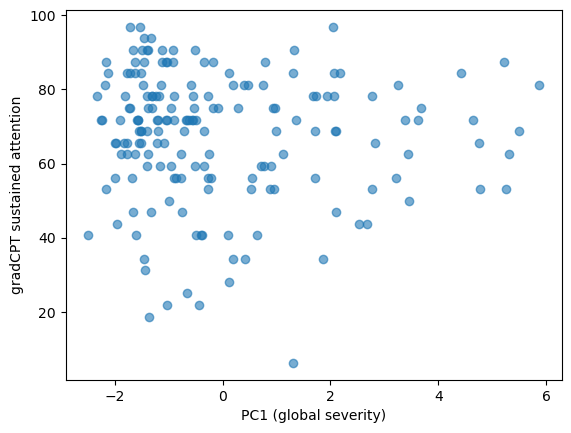

In [82]:
import matplotlib.pyplot as plt

plt.scatter(pc1_valid, gcpt_valid, alpha=0.6)
plt.xlabel("PC1 (global severity)")
plt.ylabel("gradCPT sustained attention")
plt.show()

In [83]:
merged_cog.loc[valid.index].groupby("cluster")["tmb_gcpt_score"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0.0,88.0,66.474318,18.342827,18.75,56.2500,68.75,78.12,96.87
1.0,13.0,69.228462,11.612423,53.12,62.5000,68.75,78.12,87.50
2.0,34.0,72.975000,13.994673,28.12,66.4025,75.00,81.25,93.75
3.0,41.0,65.164878,18.415755,6.25,53.1200,68.75,78.12,96.87


In [84]:
import numpy as np

In [85]:
pc1 = merged_cog.loc[valid.index, "PC1"].values
att = merged_cog.loc[valid.index, "tmb_gcpt_score"].values

In [86]:
bins = pd.qcut(pc1, q=5, duplicates="drop")
pd.DataFrame({"PC1": pc1, "att": att, "bin": bins}).groupby("bin")["att"].agg(["count","mean","std"])

,count,mean,std
bin,,,
"(-2.491, -1.529]",36,70.482778,14.646706
"(-1.529, -1.049]",35,71.782857,17.538665
"(-1.049, -0.338]",35,64.014857,18.786615
"(-0.338, 1.327]",35,63.926286,19.857063
"(1.327, 5.874]",35,67.854286,14.431425


In [87]:
from scipy.stats import f_oneway

groups = [merged_cog.loc[valid.index][merged_cog.loc[valid.index]["cluster"] == c]["tmb_gcpt_score"].dropna() for c in sorted(merged_cog.loc[valid.index]["cluster"].unique())]

f_oneway(*groups)

C:\Users\mahsa\AppData\Local\Temp\ipykernel_15132\221568856.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_oneway(*groups)


F_onewayResult(statistic=np.float64(nan), pvalue=np.float64(nan))

In [88]:
[merged_cog.loc[valid.index][merged_cog.loc[valid.index]["cluster"] == c]["tmb_gcpt_score"].dropna().shape for c in sorted(merged_cog.loc[valid.index]["cluster"].unique())]

[(88,), (13,), (34,), (41,), (0,)]

In [89]:
sorted(merged_cog.loc[valid.index]["cluster"].unique())

[np.float64(0.0),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(nan)]

In [90]:
groups = [
    merged_cog.loc[valid.index]
    .query("cluster == @c")["tmb_gcpt_score"]
    .dropna()
    for c in [0,1,2,3]
]

[len(g) for g in groups]

[88, 13, 34, 41]

In [91]:
from scipy.stats import f_oneway
f_oneway(*groups)

F_onewayResult(statistic=np.float64(1.5439881717174022), pvalue=np.float64(0.2049260226746512))

In [92]:
import numpy as np

In [93]:
boot_pc1 = []

In [94]:
rng = np.random.default_rng(42)

In [95]:
for _ in range(200):
    idx = rng.integers(0, X_np.shape[0], X_np.shape[0])
    Xb = X_np[idx]
    Zb = PCA().fit_transform(StandardScaler().fit_transform(Xb))
    boot_pc1.append(Zb[:, 0])

In [96]:
np.mean([np.corrcoef(boot_pc1[i], boot_pc1[0])[0,1] for i in range(1, len(boot_pc1))])

np.float64(-0.0006764376573604897)

In [97]:
np.float64(-0.0006764376573604897)

np.float64(-0.0006764376573604897)

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [99]:
boot_loadings = []

In [100]:
scaler = StandardScaler().fit(X_np)
pca = PCA().fit(scaler.transform(X_np))
ref_loading = pca.components_[0]

In [101]:
for _ in range(200):
    idx = rng.integers(0, X_np.shape[0], X_np.shape[0])
    Xb = X_np[idx]
    scaler_b = StandardScaler().fit(Xb)
    pca_b = PCA().fit(scaler_b.transform(Xb))
    load = pca_b.components_[0]
    if np.dot(load, ref_loading) < 0:
        load = -load
    boot_loadings.append(load)

In [102]:
np.mean([np.corrcoef(boot_loadings[i], ref_loading)[0,1] for i in range(len(boot_loadings))])

np.float64(0.9966766135634363)

In [103]:
boot_loadings_arr = np.vstack(boot_loadings)

In [104]:
np.percentile(boot_loadings_arr, [2.5, 50, 97.5], axis=0)

array([[ 0.29730329, -0.35266062, -0.25007651,  0.43032522,  0.34648434,
         0.19051636,  0.29010805,  0.4318318 ],
       [ 0.34878634, -0.31636143, -0.1807595 ,  0.45490764,  0.38412967,
         0.26984339,  0.34238007,  0.45282737],
       [ 0.38671634, -0.25565264, -0.07045428,  0.47751175,  0.42170881,
         0.33391634,  0.38904687,  0.48090505]])

In [105]:
from sklearn.metrics import adjusted_rand_score

In [106]:
boot_ari = []

In [107]:
for _ in range(200):
    idx = rng.integers(0, X_np.shape[0], X_np.shape[0])
    Xb = X_np[idx]
    Zb = PCA().fit_transform(StandardScaler().fit_transform(Xb))
    cb = KMeans(n_clusters=4, random_state=42).fit_predict(Zb)
    cref = clusters[idx]
    boot_ari.append(adjusted_rand_score(cref, cb))

In [108]:
np.mean(boot_ari), np.std(boot_ari)

(np.float64(0.6316849522548327), np.float64(0.16443036035188197))

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
X_train, X_test = train_test_split(X_np, test_size=0.5, random_state=42)

In [111]:
scaler_train = StandardScaler().fit(X_train)
pca_train = PCA().fit(scaler_train.transform(X_train))

In [112]:
Z_test = pca_train.transform(scaler_train.transform(X_test))

In [113]:
pca_test = PCA().fit(StandardScaler().fit_transform(X_test))

In [114]:
np.corrcoef(pca_train.components_[0], pca_test.components_[0])[0,1]

np.float64(0.9604043171445625)

In [115]:
from sklearn.metrics import roc_auc_score

In [116]:
y = (merged.loc[X.index, "MADRS_total"] > merged.loc[X.index, "MADRS_total"].median()).astype(int)

In [117]:
roc_auc_score(y, merged.loc[X.index, "PC1"])

0.9081521739130436